In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

from bokeh.plotting import figure, show, save
from bokeh.models import GeoJSONDataSource, ColumnDataSource, HoverTool
from bokeh.io import export_png
import matplotlib.pyplot as plt

import shapely

import sys

sys.path.append("../")

from Code.helper_functions import initial_loading
from Code.loading_data import load_api_data
from Code.algorithms import clusterwise_optimization

POSTGRES password?WelkomCorne!


### Errors on loading API data
It appeared that there were some problems regarding the loading of the data using the API. The connection got actively refused. After some testing a backup plan using a try-except clausule was implemented to prevent this from happening again

In [ ]:
load_api_data(prnt=True)

In [ ]:
df_api = pd.read_csv('../Data/afval_cluster.csv', delimiter=';')
df_api = df_api[df_api['cluster_datum_einde_cluster'].isna()]
df_api = df_api[['cluster_geometrie', 'cluster_fractie_aantal', 'cluster_fractie_volume', 'bag_adres_openbare_ruimte_naam', 'gbd_buurt_code']]
df_api['cluster_x'] = df_api['cluster_geometrie'].apply(lambda x: x.split('(')[1].split(' ')[0])
df_api['cluster_y'] = df_api['cluster_geometrie'].apply(lambda x: x.split()[1][:-1])
df_api = df_api.drop(['cluster_geometrie'], axis=1).rename(columns={'cluster_fractie_aantal':'aantal_per_fractie', 'cluster_fractie_volume':'volume_per_fractie', 'bag_adres_openbare_ruimte_naam':'street_name', 'gbd_buurt_code':'buurt'})

### Reassambling the score and penalty function
There was some bad coding going on in terms of the score and penalty function. There was also new reassignment of the normalization factor. An optional parameter to print all factors instead of the total penalties was also added

In [2]:
df_zo = pd.read_csv('../Results/20200510 - cluster optimization/hillclimber_best_config20200509-1228.csv')
all_households, rel_poi_df, joined, df_afstandn2 = initial_loading()

Do you want to use addresses instead of clusters?True
What stadsdeel do you want to make as a subsection(optional parameter)?
What is the maximum amount of containers in a cluster that is considered to be useful?8
Where to get db files(local/online)?local
DB relation POIs loaded


..\Code\loading_data.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ligtin_bag_pnd_identificatie'] = \
..\Code\loading_data.py:397: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verblijfsobjecten['bag'] = verblijfsobjecten.loc[:, 'bag']\


distance matrix loaded
API data loaded
Table all households created
API and DB joined
containers per cluster determined
move_rest determined


In [4]:
from Code.helper_functions import add_shortest_distances_to_all_households, analyze_candidate_solution
from Code.loading_data import create_aansluitingen

joined_cluster_distance = joined.set_index('s1_afv_nodes')\
    .join(df_afstandn2.set_index('van_s1_afv_nodes')).reset_index()\
    .rename(columns={'index': 'van_s1_afv_nodes'})

good_result = \
    add_shortest_distances_to_all_households(all_households,
                                             joined_cluster_distance,
                                             use_count=True)

aansluitingen = create_aansluitingen(good_result, joined_cluster_distance, use_count=True)

joined_cluster_distance, good_result_rich, aansluitingen,avg_distance, penalties, simple_penalties = analyze_candidate_solution(joined, all_households, rel_poi_df, df_afstandn2, clean=False, use_count=True, return_all=True)

Average distance is : (62.003263928685136, 241.83885448044478, 157.23694656282908, 183.1696804055544, 457.354558763745, 116.08608930901478)
Penalties are: [7.058884564935224, 4.8282516591972175, 9.972741211103763, 5.354886733769256, 7.086230615433594, 5.918389537873779, 6.646135020449147, 5.277295324859796, 6.8090207969044645, 1.1074927142262387]
Simple penalties are: (217339.18800000002, 71022.0, 267216.0, 175710.0, 220772.0, 240666.0, 32320.0, 245681.0, 151041.0, 195898.0, 180889.0)


### Optimization of other fractions in places where garbage is collected from the curbs
As nearly half of the city uses curbstone rest garbage collection, these can't just be excluded. Moreover, it also prevents dumping of undeseriable containers to these areas. The optional parameter clean has to be set to False for use. Its impact on the score function is to be determined further

In [ ]:
temp = good_result[good_result['uses_container'] == False]
# temp['rest_afstand'] = 9
# temp['poi_rest'] = 9
# good_result[good_result['uses_container']== False]['rest_afstand'] = 10
# good_result[good_result['uses_container'] == False]['poi_rest'] = 10
# good_result = good_result[good_result['uses_container'] == True]
# good_result = good_result.append(temp)
good_result.loc[~good_result['uses_container'], 'rest_afstand'] = np.nan
good_result.loc[~good_result['uses_container'], 'poi_rest'] = np.nan
good_result

In [11]:
joined_cluster_distance = joined.set_index('s1_afv_nodes')\
    .join(df_afstandn2.set_index('van_s1_afv_nodes')).reset_index()\
    .rename(columns={'index': 'van_s1_afv_nodes'})

good_result = \
    add_shortest_distances_to_all_households(all_households,
                                             joined_cluster_distance,
                                             use_count=True)

aansluitingen = create_aansluitingen(good_result, joined_cluster_distance, use_count=True)

joined_cluster_distance, good_result_rich, aansluitingen,avg_distance, penalties = analyze_candidate_solution(joined, all_households, rel_poi_df, df_afstandn2, clean=False, use_count=True, return_all=True)

Average distance is : 146.19040921349318
Penalties are: [13.986307090752906, 28.69377675645507, 9.378843150706075, 7.499677129681308, 7.517156350302604, 11.778384058219553, 6.732492989613896, 8.73765968127664, 4.993827792493072, 1.928099773320404]


### Plotting of distances and penalties
As optimization of just one of the parameters is possible within reasonable limits, the search arises for a way to compare these. One of the mentioned options was to optimize on one parameter, and hopefully find some point that is ideal. As the normal distance doesn't show anything, the best distance should be extracted

In [7]:
def plot_optimization(filename):
    df_plot1 = pd.read_csv(filename)
    df_plot1['diff'] = df_plot1['penalties'] - df_plot1['best']
    # df_plot1['total'] = df_plot1['avg_distance'] + df_plot1['penalties']
    df_plot1['best_dist'] = df_plot1[df_plot1['diff'] < 0]['avg_distance']
    df_plot1['best_dist'] = df_plot1['best_dist'].fillna(method='ffill')
    ax = df_plot1['best_dist'].plot(color='orange')
    ax.set_ylabel('average walking distance(meters)', color='orange')
    ax = df_plot1['best'].plot(color='blue', secondary_y=True)
    ax.set_ylabel('penalty score', color='blue')
    
    return ax

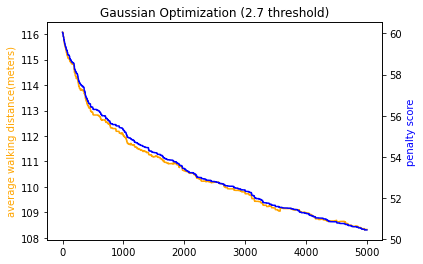

In [8]:
fig1 = plot_optimization('hillclimber20200623-1448.csv')
fig1.set_title('Gaussian Optimization (2.7 threshold)')
fig1.figure.savefig('Total27.pdf')
fig1.figure.savefig('Total27.png')

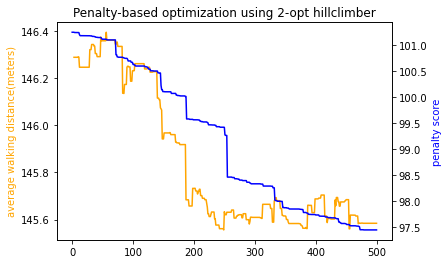

In [317]:
fig1 = plot_optimization('hillclimber20200631-0013.csv')
fig1.set_title('Penalty-based optimization using 2-opt hillclimber')
fig1.figure.savefig('2opt.pdf')

In [ ]:
plot_optimization('../Results/20200510 - cluster optimization/hillclimber20200510-1050.csv')

In [ ]:
plot_optimization('../Results/20200510 - cluster optimization/hillclimber20200512-0813.csv')

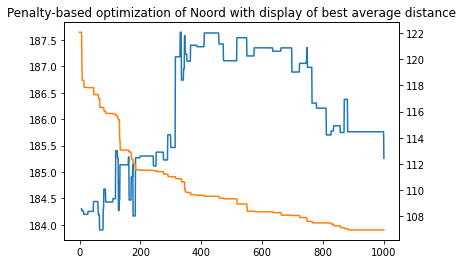

In [121]:
fig = plot_optimization('hillclimber20200516-2253.csv')
fig.set_title('Penalty-based optimization of Noord with display of best average distance')
fig.figure.savefig('noord.pdf')

It appears that an optimization approach where one of the parameters is chosen and constraints are set on the detoriation of the other may be an appropriate way to go. 

### Weight factors based on the amount of containers per fraction
The summation of the penalties and walking distances for the different fractions is hard to make, as some kind of weighing needs to be applied. One of the new approaches would be to determine these weights based on the amount of containers that is present, as this would probably correlate with the amount of garbage produced and the relative importance of the different fractions.

In [ ]:
joined_clean = joined[joined['totaal'] < 9]
temp = joined_clean[['rest', 'plastic', 'papier', 'glas', 'textiel', 'totaal']].sum()
temp

Based on these numbers the weights would be assigned the following way: Rest(0.61458), Plastic(0.088776), Papier(0.15774), Glas(0.11350) and Textiel(0.025397). This will be set as the default value for the penalties.

### Preventing the extra placement of Rest containers in light grey areas
As there are certain areas where restafval is picked up, it doesn't make sense to place extra rest containers there. It should be set as a hard constraint that this is not possible, to prevent certain dumping of containers in these areas. The first snippet of code is added to the loading phases to keep track of the possibilities for each cluster to add rest containers. The constraint that move_rest has to be true is added to the optimization algorithms

In [ ]:
from Code.loading_data import load_geodata_containers, address_in_service_area
shapefile = load_geodata_containers()
joined['move_rest'] = joined.apply(lambda row: address_in_service_area(row['cluster_x'], row['cluster_y'], polygon_list=shapefile), axis=1)
# joined[~joined['move_rest']][['rest', 'plastic', 'papier', 'glas', 'textiel', 'totaal']].sum()

In [ ]:
import random
r = joined
mod_max = 5

fractions = ['rest', 'plastic', 'papier', 'glas', 'textiel']
no_modifications = random.randint(1, mod_max)
#         print(no_modifications)
for j in range(no_modifications):
    valid = False
    while not valid:
        location_a = random.randint(0, r.shape[0]-1)
        fraction_a = random.choice(fractions)
        location_b = random.randint(0, r.shape[0]-1)
        fraction_b = random.choice(fractions)
        print(location_a, fraction_a, location_b, fraction_b, r.at[location_a, 'move_rest'])

        if int(r.at[location_a, fraction_b]) > 0 and \
                int(r.at[location_b, fraction_a]) > 0 and \
                fraction_a != fraction_b and not (fraction_a == 'rest' and
                                                  ~r.at[location_a, 'move_rest']):

            r.at[location_a, fraction_a] = \
                int(r.at[location_a, fraction_a]) + 1
            r.at[location_a, fraction_b] = \
                int(r.at[location_a, fraction_b]) - 1
            r.at[location_b, fraction_a] = \
                int(r.at[location_b, fraction_a]) - 1
            r.at[location_b, fraction_b] = \
                int(r.at[location_b, fraction_b]) + 1

            valid = True

In [9]:
joined = joined.drop(['index', 'Unnamed: 0'], axis=1)
joined

,cluster_x,cluster_y,s1_afv_rel_nodes_poi,bk_afv_rel_nodes_poi,s1_afv_nodes,s1_afv_poi,mf_insert_datetime,mf_update_datetime,mf_row_hash,mf_deleted_ind,...,buurt,wijk,stadsdeel,rest,plastic,papier,glas,textiel,totaal,move_rest
0,112740,487843,403086.0,112740.024~487843.078~afval_cluster~112740.024...,886520.0,86962.0,2020-04-01 13:57:12,2020-04-01 13:57:12,eff913f6-7550-319a-c7ff-eef1e9957e69,False,...,F80b,F80,F,0,1,1,1,0,3,False
1,112973,485077,157994.0,112973.480~485077.400~afval_cluster~112973.480...,641281.0,2280.0,2020-04-01 13:57:12,2020-04-01 13:57:12,ae17c84f-a562-e8b1-b8ab-9cfab692be79,False,...,F84b,F84,F,2,0,0,0,0,2,True
2,113012,484958,236214.0,113011.560~484957.980~afval_cluster~113011.560...,719542.0,131802.0,2020-04-01 13:57:12,2020-04-01 13:57:12,f6ff7538-a0fe-41a3-e871-2d2238f982d2,False,...,F84b,F84,F,1,0,1,0,0,2,True
3,113044,485173,139319.0,113043.960~485172.926~afval_cluster~113043.960...,622599.0,159060.0,2020-04-01 13:57:12,2020-04-01 13:57:12,842d1ea8-2d83-af0c-7450-b73071e6f847,False,...,F84b,F84,F,2,0,0,0,0,2,True
4,113049,487544,173098.0,113048.719~487543.976~afval_cluster~113048.719...,656393.0,121427.0,2020-04-01 13:57:12,2020-04-01 13:57:12,ec58fd32-090e-5c71-1fd6-65aef5f13c4a,False,...,F80b,F80,F,0,1,1,1,0,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5461,129532,484419,21341.0,129531.501~484418.765~afval_cluster~129531.501...,504553.0,1568.0,2020-04-01 13:57:12,2020-04-01 13:57:12,05f27cbc-2155-2c07-2fe4-2ee458c837f8,False,...,M51b,M51,M,1,0,0,0,0,1,True
5462,129621,479867,271956.0,129620.723~479866.800~afval_cluster~129620.723...,755306.0,55484.0,2020-04-01 13:57:12,2020-04-01 13:57:12,cc430177-0415-98b3-8362-2f1d2a7205d3,False,...,T98a,T98,T,0,0,0,1,0,1,False
5463,129755,479991,15018.0,129754.839~479990.691~afval_cluster~129754.839...,498227.0,252.0,2020-04-01 13:57:12,2020-04-01 13:57:12,f05ceb3e-4071-c0a2-b54f-9e4bc29c2021,False,...,T98a,T98,T,0,1,1,1,1,4,False
5464,129798,479676,412206.0,129798.472~479676.098~afval_cluster~129798.472...,895643.0,89247.0,2020-04-01 13:57:12,2020-04-01 13:57:12,5b1a3b4d-d0b0-1485-6693-682f0b8717ff,False,...,T98a,T98,T,0,1,1,1,0,3,False


#### Replacement of the function for Gaussian distribution hillclimber

In [110]:
import random
from collections import Counter

def hillclimber_variable_mutations(df, x=1.9):
    """
    Hillclimb with variable mutation strategy.

    This function uses Gaussian distribution to determine the amount of
    clusters to randomly re-assign. This can be modified by changing the
    optional parameter x. Its default setting of 1.9 allows for a small change.
    It returns a modified version of the input dataframe with some changes
    according to the specified x.
    """
    df = df.fillna(0)
    df['p'] = np.random.normal(0, 1, size=df.shape[0])
    df_to_change = df[df['p'] > x]
    if df_to_change.shape[0] < 2:  # Nothing happens in this case
        return df, df_to_change.shape[0]
    df = df[df['p'] < x]
    
    print("Amount of clusters to change: " + str(df_to_change.shape[0]))
    
    # Create upper threshold for grey area clusters
    df_to_change['rest_threshold'] = df_to_change['rest']
    df_to_change.loc[df_to_change['move_rest'],'rest_threshold'] = 999
    print(df_to_change['rest_threshold'].value_counts())

    # Extract all fractions
    rest = int(df_to_change['rest'].sum()) * ['rest']
    plastic = int(df_to_change['plastic'].sum()) * ['plastic']
    papier = int(df_to_change['papier'].sum()) * ['papier']
    glas = int(df_to_change['glas'].sum()) * ['glas']
    textiel = int(df_to_change['textiel'].sum()) * ['textiel']
    fracties = rest + plastic + papier + glas + textiel
    
    # lose the old configurations
    df_to_change = df_to_change.drop(['rest', 'plastic', 'papier',
                                  'glas', 'textiel'], axis=1)
    
    df_to_change = df_to_change.sort_values(by='rest_threshold')
    
    # Check if the new solution is valid. If not, repeat
    valid = False
    while not valid:
        fracties = plastic + papier + glas + textiel
        random.shuffle(fracties)
        fractions_per_cluster = []
        start_pnt = 0
        to_change = True
        for i in range(df_to_change.shape[0]):
            if df_to_change.iloc[i]['rest_threshold'] > 0 and to_change:
                to_change = False
                fracties = fracties + rest
                random.shuffle(fracties)
            length = df_to_change['totaal'].iloc[i]
            fractions_per_cluster.append(fracties[start_pnt:start_pnt + length])
            start_pnt += length
        df_to_change['new_containers'] = fractions_per_cluster
        print(df_to_change[['rest_threshold', 'new_containers']].head())

    
        df_to_change['rest'], df_to_change['plastic'], df_to_change['papier'], \
            df_to_change['glas'], df_to_change['textiel'] = \
            zip(*df_to_change['new_containers'].apply(lambda x: count(x)))
        if df_to_change[(df_to_change['rest'] > df_to_change['rest_threshold']) & (df_to_change['rest_threshold'] < 999)].shape[0] == 0:
            valid=True
        else:
            print(df_to_change[(df_to_change['rest'] > df_to_change['rest_threshold']) & (df_to_change['rest_threshold'] < 999)][['rest', 'rest_threshold']])

    df = df.append(df_to_change, ignore_index=True)
    df = df.drop(['p', 'new_containers'], axis=1)
    return df, df_to_change.shape[0]

def count(lst):
    """
    Count occurence of fractions in list.

    This function is part of an apply relation. It takese as input a list of
    different fractions. It returns the occurence of all these fractions based
    on a predefined format to be included as columns in a pandas dataframe.
    """
    cnt = Counter()
    for word in lst:
        cnt[word] += 1
    return cnt['rest'], cnt['plastic'], cnt['papier'], cnt['glas'], \
        cnt['textiel']

In [111]:
joined2 = hillclimber_variable_mutations(joined)

Amount of clusters to change: 179
999    162
1       10
2        4
0        2
3        1
Name: rest_threshold, dtype: int64
      rest_threshold    new_containers
681                0         [plastic]
2817               0  [papier, papier]
376                1    [rest, papier]
881                1            [rest]
583                1          [papier]
      rest  rest_threshold
207      2               1
2932     4               2
477      4               3
      rest_threshold  new_containers
681                0          [glas]
2817               0  [glas, papier]
376                1    [rest, rest]
881                1          [rest]
583                1          [rest]
      rest  rest_threshold
376      2               1
207      3               1
2932     4               2
477      4               3
      rest_threshold  new_containers
681                0       [plastic]
2817               0  [papier, glas]
376                1  [rest, papier]
881                1         

      rest_threshold  new_containers
681                0        [papier]
2817               0  [glas, papier]
376                1  [rest, papier]
881                1          [rest]
583                1          [rest]
      rest  rest_threshold
207      3               1
2932     4               2
477      5               3
      rest_threshold   new_containers
681                0        [plastic]
2817               0  [plastic, glas]
376                1     [rest, rest]
881                1           [rest]
583                1           [glas]
      rest  rest_threshold
376      2               1
207      2               1
2932     3               2
477      4               3
      rest_threshold   new_containers
681                0         [papier]
2817               0  [plastic, glas]
376                1   [papier, rest]
881                1           [rest]
583                1           [rest]
      rest  rest_threshold
207      2               1
2932     4               

477      5               3
      rest_threshold new_containers
681                0      [plastic]
2817               0   [glas, glas]
376                1   [glas, rest]
881                1      [plastic]
583                1       [papier]
      rest  rest_threshold
207      3               1
2932     3               2
477      5               3
      rest_threshold  new_containers
681                0        [papier]
2817               0  [glas, papier]
376                1    [rest, rest]
881                1          [rest]
583                1          [rest]
     rest  rest_threshold
376     2               1
207     3               1
477     4               3
      rest_threshold   new_containers
681                0           [glas]
2817               0   [papier, glas]
376                1  [plastic, rest]
881                1         [papier]
583                1           [rest]
     rest  rest_threshold
207     2               1
477     4               3
      rest_thresh

      rest_threshold     new_containers
681                0           [papier]
2817               0  [papier, plastic]
376                1       [rest, rest]
881                1             [rest]
583                1             [glas]
     rest  rest_threshold
376     2               1
207     2               1
477     6               3
      rest_threshold    new_containers
681                0         [textiel]
2817               0  [papier, papier]
376                1      [rest, rest]
881                1          [papier]
583                1            [rest]
      rest  rest_threshold
376      2               1
2932     4               2
477      5               3
      rest_threshold     new_containers
681                0           [papier]
2817               0     [glas, papier]
376                1  [plastic, papier]
881                1             [rest]
583                1             [rest]
     rest  rest_threshold
207     3               1
477     5             

      rest_threshold     new_containers
681                0             [glas]
2817               0  [plastic, papier]
376                1     [rest, papier]
881                1             [glas]
583                1             [rest]
      rest  rest_threshold
207      2               1
2932     3               2
      rest_threshold  new_containers
681                0          [glas]
2817               0  [glas, papier]
376                1  [papier, rest]
881                1          [rest]
583                1          [glas]
     rest  rest_threshold
207     3               1
477     4               3
      rest_threshold      new_containers
681                0            [papier]
2817               0  [plastic, plastic]
376                1        [rest, rest]
881                1              [rest]
583                1              [rest]
      rest  rest_threshold
376      2               1
207      2               1
2932     3               2
      rest_threshold   ne

      rest_threshold  new_containers
681                0          [glas]
2817               0  [glas, papier]
376                1  [papier, rest]
881                1          [rest]
583                1          [rest]
      rest  rest_threshold
207      3               1
2932     3               2
477      6               3
      rest_threshold    new_containers
681                0            [glas]
2817               0  [papier, papier]
376                1      [rest, rest]
881                1          [papier]
583                1            [rest]
     rest  rest_threshold
376     2               1
207     2               1
477     4               3
      rest_threshold     new_containers
681                0          [plastic]
2817               0  [papier, plastic]
376                1       [rest, rest]
881                1             [rest]
583                1             [glas]
      rest  rest_threshold
376      2               1
207      2               1
2932     3 

      rest_threshold   new_containers
681                0        [plastic]
2817               0   [papier, glas]
376                1  [rest, plastic]
881                1           [rest]
583                1           [rest]
      rest  rest_threshold
207      2               1
2932     4               2
477      5               3
      rest_threshold     new_containers
681                0             [glas]
2817               0  [textiel, papier]
376                1       [glas, rest]
881                1             [rest]
583                1             [rest]
      rest  rest_threshold
207      3               1
2932     3               2
477      6               3
      rest_threshold new_containers
681                0      [plastic]
2817               0   [glas, glas]
376                1   [rest, glas]
881                1      [plastic]
583                1         [rest]
      rest  rest_threshold
207      2               1
2932     3               2
477      6         

      rest_threshold    new_containers
681                0          [papier]
2817               0  [papier, papier]
376                1      [rest, rest]
881                1            [rest]
583                1            [rest]
      rest  rest_threshold
376      2               1
207      3               1
2932     3               2
477      4               3
      rest_threshold   new_containers
681                0        [plastic]
2817               0     [glas, glas]
376                1  [rest, textiel]
881                1           [rest]
583                1           [rest]
      rest  rest_threshold
207      2               1
2932     4               2
477      5               3
      rest_threshold  new_containers
681                0       [plastic]
2817               0  [glas, papier]
376                1    [glas, glas]
881                1        [papier]
583                1          [rest]
     rest  rest_threshold
477     4               3
      rest_threshold 

      rest_threshold    new_containers
681                0         [plastic]
2817               0  [papier, papier]
376                1   [rest, plastic]
881                1            [rest]
583                1            [rest]
      rest  rest_threshold
207      2               1
2932     3               2
477      5               3
      rest_threshold     new_containers
681                0          [plastic]
2817               0  [plastic, papier]
376                1       [rest, rest]
881                1             [rest]
583                1             [rest]
      rest  rest_threshold
376      2               1
2932     4               2
      rest_threshold  new_containers
681                0          [glas]
2817               0  [glas, papier]
376                1    [glas, rest]
881                1          [rest]
583                1          [rest]
      rest  rest_threshold
207      2               1
2932     4               2
477      4               3
      r

      rest_threshold   new_containers
681                0        [plastic]
2817               0  [glas, textiel]
376                1     [rest, rest]
881                1           [glas]
583                1           [rest]
      rest  rest_threshold
376      2               1
207      3               1
2932     3               2
477      4               3
      rest_threshold      new_containers
681                0           [plastic]
2817               0  [plastic, plastic]
376                1    [papier, papier]
881                1            [papier]
583                1              [rest]
     rest  rest_threshold
207     2               1
477     4               3
      rest_threshold  new_containers
681                0       [plastic]
2817               0  [glas, papier]
376                1    [rest, rest]
881                1        [papier]
583                1        [papier]
     rest  rest_threshold
376     2               1
207     3               1
477     4    

     rest  rest_threshold
207     2               1
477     6               3
      rest_threshold   new_containers
681                0        [plastic]
2817               0  [glas, plastic]
376                1     [rest, rest]
881                1           [rest]
583                1           [glas]
     rest  rest_threshold
376     2               1
207     2               1
477     5               3
      rest_threshold     new_containers
681                0           [papier]
2817               0  [papier, plastic]
376                1       [rest, rest]
881                1             [rest]
583                1          [plastic]
      rest  rest_threshold
376      2               1
207      2               1
2932     4               2
477      4               3
      rest_threshold    new_containers
681                0          [papier]
2817               0  [papier, papier]
376                1   [rest, plastic]
881                1            [rest]
583                1

      rest_threshold  new_containers
681                0          [glas]
2817               0  [glas, papier]
376                1    [rest, rest]
881                1          [rest]
583                1          [rest]
      rest  rest_threshold
376      2               1
207      3               1
2932     3               2
477      4               3
      rest_threshold      new_containers
681                0              [glas]
2817               0  [plastic, plastic]
376                1        [rest, rest]
881                1              [rest]
583                1              [rest]
      rest  rest_threshold
376      2               1
207      2               1
2932     3               2
477      6               3
      rest_threshold    new_containers
681                0          [papier]
2817               0  [papier, papier]
376                1    [papier, rest]
881                1            [rest]
583                1          [papier]
      rest  rest_threshold
2

In [113]:
aansluitingen.to_csv('aansluitingen.csv')

### 500 random runs
These runs are necessary as a plot to demonstrate the use of iterative algorithms

In [5]:
from Code.algorithms import random_shuffling_clusters

result_dict = {}
analyze_candidate_solution(joined, all_households, rel_poi_df, df_afstandn2, clean=False, use_count=True, return_all=False)
for i in range(500):
    temp = random_shuffling_clusters(joined)
    joined_cluster_distance, good_result, aansluitingen, avg_distance, penalties = analyze_candidate_solution(temp, all_households, rel_poi_df, df_afstandn2, clean=False, use_count=True, return_all=False)
    result_dict[i] = [avg_distance, penalties]

Average distance is : 116.08608930901478
Penalties are: 60.05932817875248
Simple penalties are: 217339.18800000002


KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame.from_dict(result_dict, orient='index').rename(columns={0:'distance', 1:'penalties'})
df.plot()

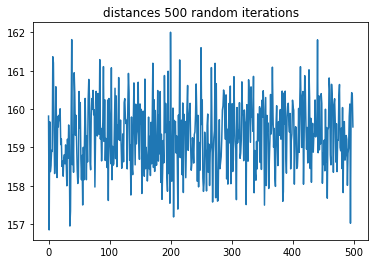

In [169]:
plotje = df['distance'].plot(title='distances 500 random iterations')
plotje.figure.savefig('500_random_distances.png')

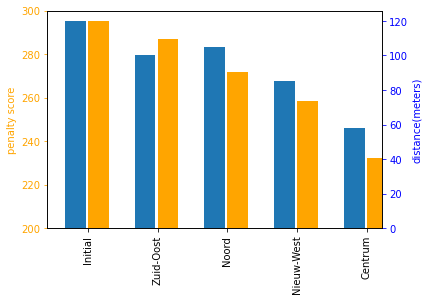

In [310]:
score = [295.12, 286.96, 271.81, 258.44, 232.12]
distances = [120, 100, 105, 85, 58]
phase = ['Initial', 'Zuid-Oost', 'Noord', 'Nieuw-West', 'Centrum']
df2 = pd.DataFrame(score, phase).rename(columns={0:'Penalty score'})
df2['distance'] = distances
plotje = df2['Penalty score'].plot(kind='bar', ylim=[200,300], width=0.3, color='orange', position=0)
plotje.set_ylabel('penalty score', color='orange')
plotje.tick_params(axis='y', colors='orange')
plotje = df2['distance'].plot(kind='bar', secondary_y=True, position=1.1, width=0.3)
plotje.set_ylabel('distance(meters)', color='blue')
plotje.tick_params(axis='y', colors='blue')

plotje.figure.savefig('subcluster_optimization_bar.png')

In [293]:
plotje = plt.figure()

<Figure size 432x288 with 0 Axes>

In [26]:
clusterwise_optimization()

How many random iterations?1
How many iterations hillclimber?1
Do you want the results saved(True/False)?False
Do you want to only use a subset of data?DfF
Do you want to use addresses over clusters?sdfg
Do you want to apply simulated annealing? (True/False)dsfg


KeyboardInterrupt: 

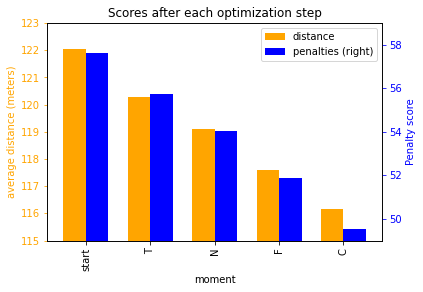

In [10]:
distances = [122.0311, 120.2687, 119.117, 117.60, 116.17]
penalties = [57.619, 55.759, 54.0249, 51.8619, 49.5515]
moments = ['start', 'T', 'N', 'F', 'C']
df = pd.DataFrame([distances, penalties, moments]).T.rename(columns={0:'distance', 1: 'penalties', 2:'moment'}).set_index('moment')
# plotje = df['penalties'].plot(kind='bar', width=0.3, color='orange', position=0, ylim=[40,60])
# # plotje.set_ylabel('penalty score', color='orange')
# # plotje.tick_params(axis='y', colors='orange')
# # plotje = df['distance'].plot(kind='bar', secondary_y=True, position=1, width=0.3)
# # plotje.set_ylim(110,124)

plotje = df.plot(secondary_y='penalties', kind='bar', ylim=[115,123], title='Scores after each optimization step', width=0.7, color=['orange', 'blue'])
plotje.set_ylabel('average distance (meters)', color='orange')
plotje.tick_params(axis='y', colors='orange')
plotje.right_ax.set_ylim(49,59)
plotje.right_ax.tick_params(axis='y', colors='blue')
plotje.right_ax.set_ylabel('Penalty score', color='blue')
plotje.figure.savefig('subcluster_optimization_bar.png')

# plotje = df2['Penalty score'].plot(kind='bar', ylim=[200,300], width=0.3, color='orange', position=0)
# plotje.set_ylabel('penalty score', color='orange')
# plotje.tick_params(axis='y', colors='orange')
# plotje = df2['distance'].plot(kind='bar', secondary_y=True, position=1.1, width=0.3)
# plotje.set_ylabel('distance(meters)', color='blue')
# plotje.tick_params(axis='y', colors='blue')

# plotje.figure.savefig('subcluster_optimization_bar.png')

How many random iterations?0
How many iterations hillclimber?0
Do you want the results saved(True/False)?False
Do you want to only use a subset of data?True
Do you want to use addresses over clusters?True
Do you want to apply simulated annealing? (True/False)False
Optimize on (score/penalties/simple)?penalties
What method (2-opt, dim Gaussian, Gaussian)?Gaussian
Do you want to use addresses instead of clusters?True
What stadsdeel do you want to make as a subsection(optional parameter)?
What is the maximum amount of containers in a cluster that is considered to be useful?8
Where to get db files(local/online)?local
DB relation POIs loaded


..\Code\loading_data.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ligtin_bag_pnd_identificatie'] = \
..\Code\loading_data.py:397: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verblijfsobjecten['bag'] = verblijfsobjecten.loc[:, 'bag']\


distance matrix loaded
API data loaded
Table all households created
API and DB joined
containers per cluster determined
move_rest determined
Average distance is : 146.29815405827264
Penalties are: 87.35350588771615
Simple penalties are: 14773.674
***************************************
146.29815405827264 87.35350588771615 0
Average distance is : 146.29815405827264
Penalties are: 87.35350588771615
Simple penalties are: 14773.674
**************************************************************
Average distance is : 122.0311572557066
Penalties are: 57.61922650072635
Simple penalties are: 172788.04200000002
**************************************************************
T finished, moving on
Average distance is : 162.28513142024923
Penalties are: 89.61712920802302
Simple penalties are: 29536.138000000003
***************************************
162.28513142024923 89.61712920802302 0
Average distance is : 162.28513142024923
Penalties are: 89.61712920802302
Simple penalties are: 29536.1380000000

,cluster_x,cluster_y,s1_afv_nodes,s1_afv_poi,type,bag,aantal_per_fractie,volume_per_fractie,street_name,buurt,wijk,stadsdeel,rest,plastic,papier,glas,textiel,totaal,move_rest
0,124549,481681,863418.0,156928.0,afval_cluster,124549.098|481681.498,[Rest:1],[Rest:5 m3],Alexander Dumaslaan,T93a,T93,T,1,0,0,0,0,1,True
1,124562,481606,594399.0,24108.0,afval_cluster,124562.398|481605.919,"[Glas:1, Papier:1]","[Glas:5 m3, Papier:5 m3]",Alexander Dumaslaan,T93a,T93,T,0,0,1,1,0,2,True
2,124599,481768,625308.0,150701.0,afval_cluster,124599.009|481768.428,[Rest:1],[Rest:5 m3],Alexander Dumaslaan,T93a,T93,T,1,0,0,0,0,1,True
3,124610,481531,576491.0,86904.0,afval_cluster,124610.194|481531.108,[Rest:1],[Rest:5 m3],Andersensingel,T93a,T93,T,1,0,0,0,0,1,True
4,124614,481406,551412.0,35258.0,afval_cluster,124614.479|481405.698,[Rest:1],[Rest:5 m3],Boris Pasternakstraat,T93a,T93,T,1,0,0,0,0,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5471,129400,484340,842091.0,157244.0,afval_cluster,129400.259|484339.644,[Rest:2],[Rest:10 m3],Emmy Andriessestraat,M51b,M51,M,2,0,0,0,0,2,True
5472,129431,484493,705430.0,37848.0,afval_cluster,129431.233|484493.029,"[Glas:1, Papier:1]","[Glas:4.69 m3, Papier:4.69 m3]",Peter Martensstraat,M51b,M51,M,0,0,1,1,0,2,True
5473,129443,484496,831336.0,144042.0,afval_cluster,129442.568|484496.286,[Plastic:1],[Plastic:5 m3],Eva Besnyöstraat,M51b,M51,M,0,1,0,0,0,1,True
5474,129485,484579,605817.0,120020.0,afval_cluster,129485.252|484578.699,[Rest:2],[Rest:9.38 m3],Wim Noordhoekkade,M51b,M51,M,2,0,0,0,0,2,True


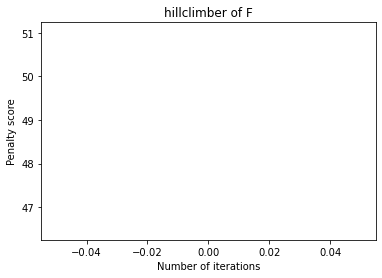

In [4]:
clusterwise_optimization()